# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




# The Dataset
> ***Brief Description:***
**Problem Statement**
Despite Rwanda's impressive agricultural development initiatives, smallholder farmers continue to face significant challenges in identifying and managing crop diseases effectively. Current approaches to crop disease management are inadequate for several reasons:

1. Limited Extension Services: Musabyimana et al. (2023) highlighted that Rwanda's extension officer-to-farmer ratio stands at 1:1,400, severely limiting timely access to expert diagnosis when disease symptoms first appear. Their research revealed that farmers typically wait 7-12 days for an extension officer visit, by which time disease spread often becomes unmanageable.
2. Knowledge Gaps: Niyonzima and Habimana (2022) conducted surveys across Rwanda's Eastern Province, finding that only 31% of smallholder farmers could correctly identify common diseases affecting their crops beyond basic visual recognition. The study emphasized how this knowledge gap leads to inappropriate treatment applications, contributing to both economic losses and environmental harm.
3. Connectivity Barriers: Uwamahoro and Bizimana (2023) analyzed technological interventions in Rwandan agriculture, noting that while existing digital solutions show promise, they predominantly require consistent internet connectivity. With only 17% of rural farming areas having reliable internet access, solutions requiring constant connectivity fail to serve the majority of Rwanda's agricultural communities.
4. Cultural and Language Limitations: Mukamana et al. (2024) demonstrated that existing agricultural advisory apps fail to account for linguistic diversity and literacy levels among Rwandan farmers. Their research showed that solutions not incorporating Kinyarwanda and visual interfaces see adoption rates below 8% among target communities.
5. RwandaCropGuard addresses these limitations by developing a locally-adapted, offline-capable classification system specifically designed for Rwandan crops, languages, and farming contexts. Unlike existing solutions that require consistent connectivity or fail to accommodate local varieties and diseases, our approach focuses on creating an accessible, culturally appropriate system that empowers smallholder farmers with immediate diagnostic capabilities.


In [54]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib


In [18]:
# --- Configuration ---
base_dir = 'dataset/Train'  # This is now your single folder with class subfolders
IMG_SIZE = (128, 128)
classes = ['Healthy', 'Powdery', 'Rust']

# --- 1. Remove corrupted images ---
def clean_images(folder):
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.exists(cls_path):
            print(f"⚠️ Folder not found: {cls_path}")
            continue
        for file in os.listdir(cls_path):
            path = os.path.join(cls_path, file)
            try:
                with Image.open(path) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError, IOError):
                print(f"🗑️ Removing corrupted image: {path}")
                os.remove(path)

# --- 2. Load dataset into X, Y ---
def load_dataset(folder):
    X, Y = [], []
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.exists(cls_path):
            print(f"⚠️ Missing class folder: {cls_path}")
            continue
        for img_name in os.listdir(cls_path):
            path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(path).convert('RGB').resize(IMG_SIZE)
                X.append(np.array(img))
                Y.append(cls)
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
                continue
    return np.array(X), np.array(Y)

# --- Run cleaning and loading ---
print("Cleaning corrupted images...")
clean_images(base_dir)

print("Loading images...")
X, Y_raw = load_dataset(base_dir)

# --- Normalize image data ---
X = X.astype('float32') / 255.0

# --- Encode labels ---
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y_raw)

# --- Split dataset into train, val, test ---
print("Splitting dataset...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.2, random_state=42, stratify=Y_test)

# --- Output status ---
print("Data prepared successfully.")
print(f"Train:     X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation:X={X_val.shape},   Y={Y_val.shape}")
print(f"Test:      X={X_test.shape},  Y={Y_test.shape}")
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Cleaning corrupted images...
Loading images...
Splitting dataset...
Data prepared successfully.
Train:     X=(1225, 128, 128, 3), Y=(1225,)
Validation:X=(245, 128, 128, 3),   Y=(245,)
Test:      X=(62, 128, 128, 3),  Y=(62,)
Class mapping: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


## Sample Image View

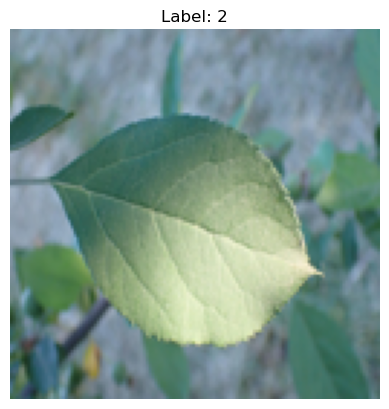

In [83]:
# Display the image
plt.imshow(X[20], cmap='gray')
plt.title(f"Label: {Y_test[20]}")
plt.axis('off')  # Hide axes for cleaner view
plt.show()

# SECTION 1: Model Architecture:
<svg viewBox="0 0 1000 600" xmlns="http://www.w3.org/2000/svg">
  <!-- Background -->
  <rect width="1000" height="600" fill="white"/>
  
  <!-- Title -->
  <text x="500" y="30" text-anchor="middle" font-family="Arial, sans-serif" font-size="20" font-weight="bold" fill="#2c3e50">
    CNN Architecture for Leaf Disease Classification
  </text>
  
  <!-- Input Layer -->
  <g id="input">
    <rect x="50" y="100" width="80" height="210" fill="#e3f2fd" stroke="#1976d2" stroke-width="2" rx="5"/>
    <text x="90" y="130" text-anchor="middle" font-family="Arial, sans-serif" font-size="12" font-weight="bold" fill="#1976d2">Input</text>
    <text x="90" y="150" text-anchor="middle" font-family="Arial, sans-serif" font-size="10" fill="#1976d2">128×128×3</text>
    <text x="90" y="165" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">(RGB Image)</text>
  </g>
  
  <!-- Conv2D + BatchNorm + MaxPool Block 1 -->
  <g id="conv1">
    <rect x="170" y="80" width="100" height="120" fill="#ffecb3" stroke="#f57f17" stroke-width="2" rx="5"/>
    <text x="220" y="100" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#f57f17">Conv2D</text>
    <text x="220" y="115" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">32 filters</text>
    <text x="220" y="130" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">3×3 kernel</text>
    <text x="220" y="145" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">ReLU</text>
    <rect x="175" y="160" width="90" height="15" fill="#fff3e0" stroke="#ff9800" stroke-width="1" rx="2"/>
    <text x="220" y="170" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#ff9800">BatchNorm</text>
        <rect x="175" y="180" width="90" height="15" fill="#e8f5e8" stroke="#4caf50" stroke-width="1" rx="2"/>
    <text x="220" y="190" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#4caf50">MaxPool 2×2</text>
        <text x="220" y="210" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">64×64×32</text>
  </g>
  
  <!-- Conv2D + BatchNorm + MaxPool Block 2 -->
  <g id="conv2">
    <rect x="310" y="80" width="100" height="120" fill="#ffecb3" stroke="#f57f17" stroke-width="2" rx="5"/>
    <text x="360" y="100" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#f57f17">Conv2D</text>
    <text x="360" y="115" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">64 filters</text>
    <text x="360" y="130" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">3×3 kernel</text>
    <text x="360" y="145" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">ReLU</text>
    <rect x="315" y="160" width="90" height="15" fill="#fff3e0" stroke="#ff9800" stroke-width="1" rx="2"/>
    <text x="360" y="170" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#ff9800">BatchNorm</text>
    <rect x="315" y="180" width="90" height="15" fill="#e8f5e8" stroke="#4caf50" stroke-width="1" rx="2"/>
    <text x="360" y="190" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#4caf50">MaxPool 2×2</text>
    <text x="360" y="210" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">32×32×64</text>
  </g>
  
  <!-- Conv2D + BatchNorm + MaxPool Block 3 -->
  <g id="conv3">
    <rect x="450" y="80" width="100" height="120" fill="#ffecb3" stroke="#f57f17" stroke-width="2" rx="5"/>
    <text x="500" y="100" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#f57f17">Conv2D</text>
    <text x="500" y="115" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">128 filters</text>
    <text x="500" y="130" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#f57f17">3×3 kernel</text>
    <text x="500" y="145" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">ReLU</text>
    <rect x="455" y="160" width="90" height="15" fill="#fff3e0" stroke="#ff9800" stroke-width="1" rx="2"/>
    <text x="500" y="170" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#ff9800">BatchNorm</text>
    <rect x="455" y="180" width="90" height="15" fill="#e8f5e8" stroke="#4caf50" stroke-width="1" rx="2"/>
    <text x="500" y="190" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#4caf50">MaxPool 2×2</text>
    <text x="500" y="210" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">16×16×128</text>
  </g>
  
  <!-- Flatten Layer -->
  <g id="flatten">
    <rect x="590" y="120" width="60" height="60" fill="#f3e5f5" stroke="#9c27b0" stroke-width="2" rx="5"/>
    <text x="620" y="140" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#9c27b0">Flatten</text>
    <text x="620" y="160" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">32768</text>
  </g>
  
  <!-- Dense Layer 1 -->
  <g id="dense1">
    <rect x="690" y="100" width="80" height="100" fill="#e1f5fe" stroke="#0277bd" stroke-width="2" rx="5"/>
    <text x="730" y="120" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#0277bd">Dense</text>
    <text x="730" y="135" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#0277bd">128 units</text>
    <text x="730" y="150" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">ReLU</text>
    <rect x="695" y="160" width="70" height="15" fill="#ffebee" stroke="#d32f2f" stroke-width="1" rx="2"/>
    <text x="730" y="170" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#d32f2f">Dropout</text>
    <rect x="695" y="180" width="70" height="15" fill="#e1f5fe" stroke="#0277bd" stroke-width="1" rx="2"/>
    <text x="730" y="190" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#0277bd">Dense 64</text>
  </g>
  
  <!-- Output Layer -->
  <g id="output">
    <rect x="810" y="120" width="80" height="100" fill="#e8f5e8" stroke="#2e7d32" stroke-width="2" rx="5"/>
    <text x="850" y="140" text-anchor="middle" font-family="Arial, sans-serif" font-size="11" font-weight="bold" fill="#2e7d32">Output</text>
    <text x="850" y="155" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#2e7d32">3 classes</text>
    <text x="850" y="170" text-anchor="middle" font-family="Arial, sans-serif" font-size="9" fill="#666">Softmax</text>
    <!-- Class labels -->
    <text x="850" y="190" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#2e7d32">Healthy</text>
    <text x="850" y="202" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#2e7d32">Powdery</text>
    <text x="850" y="214" text-anchor="middle" font-family="Arial, sans-serif" font-size="8" fill="#2e7d32">Rust</text>
  </g>
  
  <!-- Arrows -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="#666"/>
    </marker>
  </defs>
  
  <line x1="130" y1="250" x2="170" y2="140" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="270" y1="140" x2="310" y2="140" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="410" y1="140" x2="450" y2="140" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="550" y1="140" x2="590" y2="150" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="650" y1="150" x2="690" y2="150" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <line x1="770" y1="150" x2="810" y2="150" stroke="#666" stroke-width="2" marker-end="url(#arrowhead)"/>
  <!-- Feature extraction and classification labels -->
  <text x="360" y="270" text-anchor="middle" font-family="Arial, sans-serif" font-size="14" font-weight="bold" fill="#34495e">Feature Extraction</text>
  <text x="750" y="270" text-anchor="middle" font-family="Arial, sans-serif" font-size="14" font-weight="bold" fill="#34495e">Classification</text>
  <!-- Dashed line separator -->
  <line x1="570" y1="50" x2="570" y2="280" stroke="#bdc3c7" stroke-width="2" stroke-dasharray="5,5"/>
  
  <!-- Architecture details -->
  <g id="details">
    <rect x="50" y="320" width="800" height="220" fill="#ffffff" stroke="#bdc3c7" stroke-width="1" rx="5"/>
    <text x="70" y="345" font-family="Arial, sans-serif" font-size="14" font-weight="bold" fill="#2c3e50">Model Configuration:</text>
    <text x="70" y="370" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Input Shape: 128×128×3 (RGB leaf images)</text>
    <text x="70" y="385" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Convolutional Layers: 3 blocks with increasing filters (32→64→128)</text>
    <text x="70" y="400" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Each Conv block: Conv2D → BatchNormalization → MaxPooling2D</text>
    <text x="70" y="415" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Dense Layers: 128 → 64 → 3 (with optional dropout)</text>
    <text x="70" y="430" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Activation: ReLU (hidden), Softmax (output)</text>
    <text x="70" y="445" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Loss Function: Sparse Categorical Crossentropy</text>
    <text x="70" y="460" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Optional Features: L1/L2 Regularization, Dropout, Early Stopping</text>
    <text x="70" y="475" font-family="Arial, sans-serif" font-size="11" fill="#34495e">• Optimizers: Adam, RMSprop (configurable learning rate)</text>
    <text x="70" y="505" font-family="Arial, sans-serif" font-size="12" font-weight="bold" fill="#e74c3c">Target Classes:</text>
    <circle cx="90" cy="520" r="4" fill="#27ae60"/>
    <text x="105" y="525" font-family="Arial, sans-serif" font-size="11" fill="#27ae60">Healthy - Normal leaf condition</text>
    <circle cx="280" cy="520" r="4" fill="#f39c12"/>
    <text x="295" y="525" font-family="Arial, sans-serif" font-size="11" fill="#f39c12">Powdery - Powdery mildew infection</text>
    <circle cx="520" cy="520" r="4" fill="#e67e22"/>
    <text x="535" y="525" font-family="Arial, sans-serif" font-size="11" fill="#e67e22">Rust - Rust disease infection</text>
  </g>
</svg>


# Task: Define a function that creates models without and With specified Optimization techniques


## Create Classic Logistic Regression Model

In [19]:
def train_logistic_regression(X, y, test_size=0.2, random_state=42):
    # ===========================
    # Preprocessing
    # ===========================
    X_flat = X.reshape(len(X), -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # ===========================
    # Logistic Regression Setup
    # ===========================
    model = LogisticRegression(
        penalty='l2',            # regularization type
        C=1.0,                   # inverse of regularization strength
        solver='saga',          # solver that supports multinomial loss
        max_iter=1000,           # maximum iterations for convergence
        multi_class='multinomial', # softmax-style multiclass classification
        class_weight='balanced',   # handle class imbalance
        random_state=random_state
    )

    # ===========================
    # Train
    # ===========================
    model.fit(X_train, y_train)
 # ===========================
    # Evaluate
    # ===========================
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[str(i) for i in np.unique(y)]))

    print(f"\n✅ Logistic Regression Performance:\n"
          f"Accuracy : {acc:.4f}\n"
          f"Precision: {prec:.4f}\n"
          f"Recall   : {rec:.4f}\n"
          f"F1 Score : {f1:.4f}")

    return model


## Create a function to create model

In [20]:

def define_model(optimizer_name=None, 
                 regularizer_type=None, 
                 early_stopping=False, 
                 dropout_rate=0.0, 
                 learning_rate=None, 
                 input_shape=(128, 128, 3), 
                 num_classes=3):
    
    model = Sequential()
    
    # Choose regularization if specified
    reg = None
    if regularizer_type == 'l2':
        reg = l2(0.001)
    elif regularizer_type == 'l1':
        reg = l1(0.001)

    # ========== Convolutional Base ==========
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=reg))  # More filters = deeper features
    model.add(BatchNormalization())  # Keeps training stable
    model.add(MaxPooling2D((2, 2)))  # Halves feature map dimensions again

    # ========== Dense Head ==========
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=reg))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dense(num_classes, activation='softmax'))

    # ========== Optimizer ==========
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate) if learning_rate else Adam()
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate) if learning_rate else RMSprop()
    else:
        optimizer = 'adam'  # fallback/default

    # ========== Compile ==========
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # ========== EarlyStopping Callback ==========
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    return model, callbacks


## Model evalution

In [ ]:
def evaluate_model(model, X_test, y_test,show=True):
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    if show:
        print("\n📊 Classification Report:\n")
        print(classification_report(y_test, y_pred))
        print(f"✅ Accuracy:  {acc:.4f}")
        print(f"✅ Precision: {prec:.4f}")
        print(f"✅ Recall:    {rec:.4f}")
        print(f"✅ F1 Score:  {f1:.4f}")

    # Confusion Matrix
    if show:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('🌀 Confusion Matrix')
        plt.show()

    # ROC-AUC
    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        if show:
            print(f"✅ ROC AUC Score: {roc_auc:.4f}")
    except:
        print("⚠️ Could not calculate ROC AUC — ensure y_test and y_prob formats are correct.")

    return acc, prec, rec, f1, roc_auc if 'roc_auc' in locals() else None


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [22]:
def loss_curve_plot(history):
    """Plot training and validation loss curves from model history.
    
    Args:
        history: A Keras History object containing training metrics.
    """
    plt.figure(figsize=(10, 6))  # Set a proper figure size
    
    epochs = range(len(history.history['loss']))
    
    # Plot with better marker styles and line widths
    plt.plot(epochs, history.history['loss'], 'bo-', linewidth=2, markersize=6, label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r^-', linewidth=2, markersize=6, label='Validation loss')
    
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Improve legend positioning and appearance
    plt.legend(fontsize=12, framealpha=1, facecolor='white')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

## Model Instances

### classic logistic regression

In [23]:
model_0 = train_logistic_regression(X, Y)

/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       106
           1       0.86      0.91      0.88       100
           2       0.79      0.60      0.69       101

    accuracy                           0.79       307
   macro avg       0.79      0.79      0.78       307
weighted avg       0.79      0.79      0.78       307


✅ Logistic Regression Performance:
Accuracy : 0.7883
Precision: 0.7909
Recall   : 0.7883
F1 Score : 0.7835


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### instance 1

Epoch 1/50
24/24 [==============================] - 6s 220ms/step - loss: 1.3054 - accuracy: 0.7235 - val_loss: 4.5889 - val_accuracy: 0.3061
Epoch 2/50
24/24 [==============================] - 5s 203ms/step - loss: 0.3077 - accuracy: 0.8898 - val_loss: 3.8392 - val_accuracy: 0.3061
Epoch 3/50
24/24 [==============================] - 5s 215ms/step - loss: 0.1386 - accuracy: 0.9408 - val_loss: 3.9989 - val_accuracy: 0.3061
Epoch 4/50
24/24 [==============================] - 5s 203ms/step - loss: 0.0359 - accuracy: 0.9878 - val_loss: 4.3455 - val_accuracy: 0.3061
Epoch 5/50
24/24 [==============================] - 5s 205ms/step - loss: 0.0266 - accuracy: 0.9939 - val_loss: 2.1312 - val_accuracy: 0.4449
Epoch 6/50
24/24 [==============================] - 5s 201ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 2.1226 - val_accuracy: 0.3102
Epoch 7/50
24/24 [==============================] - 5s 200ms/step - loss: 0.0356 - accuracy: 0.9847 - val_loss: 3.0480 - val_accuracy: 0.3061
Epoch 

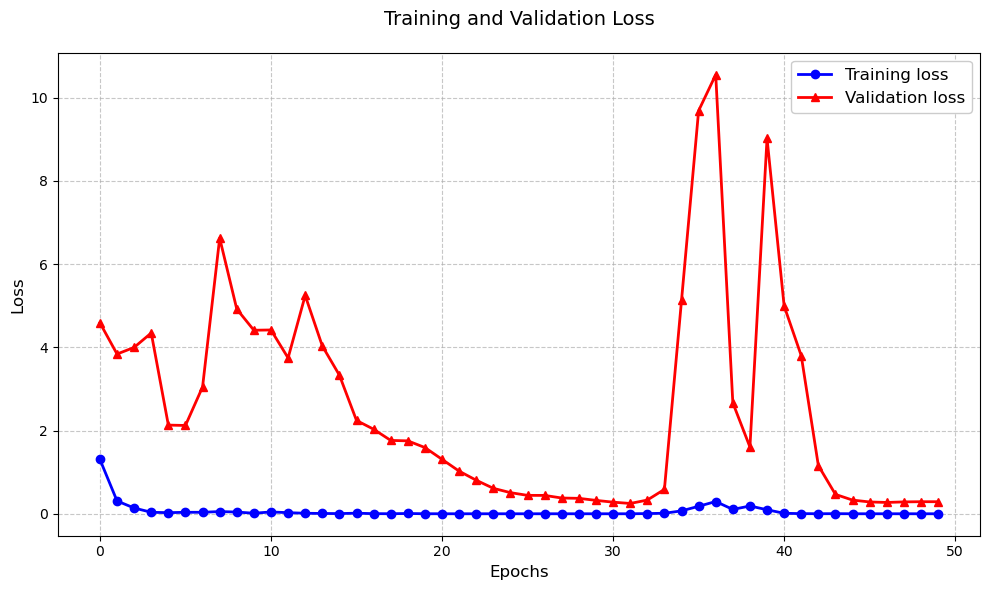

2/2 [==============================] - 0s 58ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.89      0.85      0.87        20
           2       0.90      0.90      0.90        20

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.90      0.90      0.90        62

✅ Accuracy:  0.9032
✅ Precision: 0.9029
✅ Recall:    0.9032
✅ F1 Score:  0.9027


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


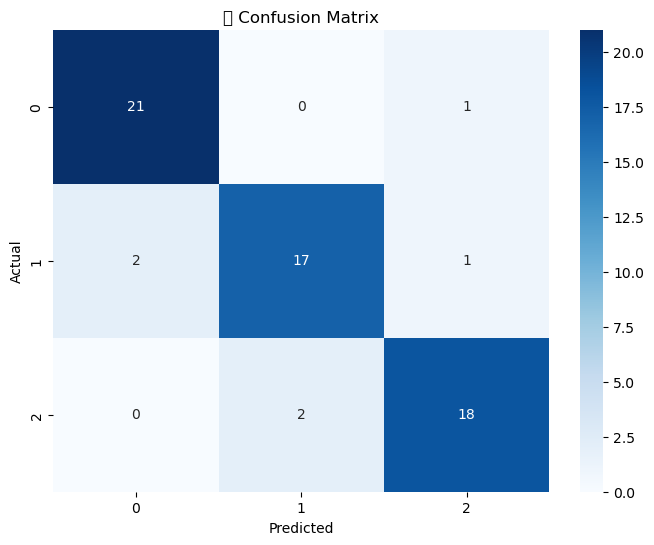

✅ ROC AUC Score: 0.9906


(0.9032258064516129,
 0.9029305381265225,
 0.9032258064516129,
 0.9027295285359803)

In [25]:
model_1, callbacks_1 = define_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train)),)
history_1 = model_1.fit(X_train, Y_train, validation_split=0.2, epochs=50, batch_size=42, verbose=1)
loss_curve_plot(history_1)
evaluate_model(model_1, X_test, Y_test) 



### instance 2

Epoch 1/500
31/31 [==============================] - 6s 165ms/step - loss: 1.6363 - accuracy: 0.6786 - val_loss: 2.8091 - val_accuracy: 0.3510
Epoch 2/500
31/31 [==============================] - 5s 155ms/step - loss: 0.6008 - accuracy: 0.8541 - val_loss: 3.8775 - val_accuracy: 0.4204
Epoch 3/500
31/31 [==============================] - 5s 161ms/step - loss: 0.3576 - accuracy: 0.9041 - val_loss: 2.8988 - val_accuracy: 0.5265
Epoch 4/500
31/31 [==============================] - 5s 160ms/step - loss: 0.2553 - accuracy: 0.9255 - val_loss: 2.8226 - val_accuracy: 0.5714
Epoch 5/500
31/31 [==============================] - 5s 160ms/step - loss: 0.1667 - accuracy: 0.9531 - val_loss: 6.3205 - val_accuracy: 0.3429
Epoch 6/500
31/31 [==============================] - 5s 156ms/step - loss: 0.1081 - accuracy: 0.9622 - val_loss: 10.7459 - val_accuracy: 0.3061


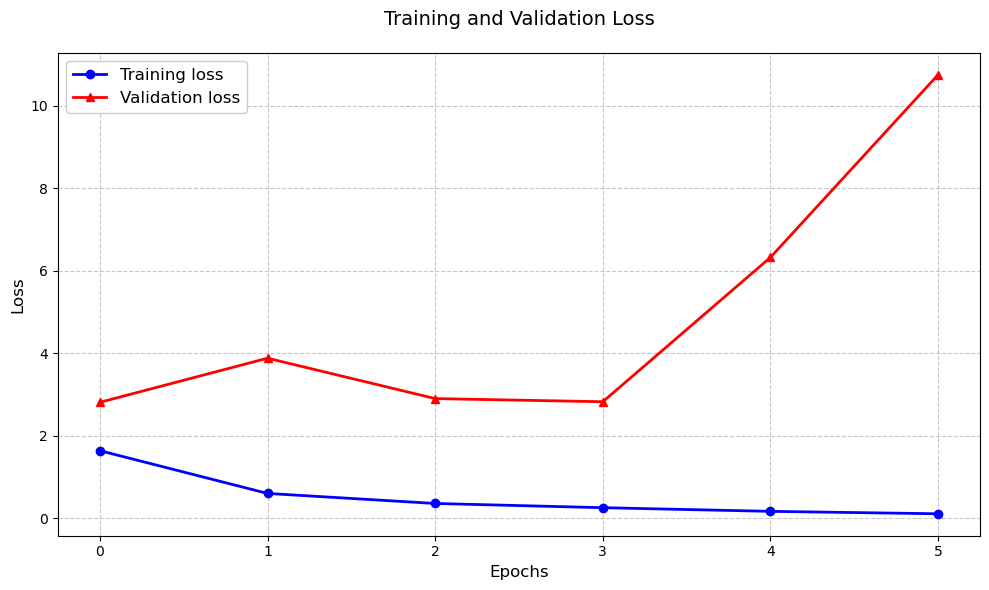

2/2 [==============================] - 0s 55ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.29      0.09      0.14        22
           1       0.35      0.95      0.51        20
           2       0.00      0.00      0.00        20

    accuracy                           0.34        62
   macro avg       0.21      0.35      0.21        62
weighted avg       0.21      0.34      0.21        62

✅ Accuracy:  0.3387
✅ Precision: 0.2128
✅ Recall:    0.3387
✅ F1 Score:  0.2124


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

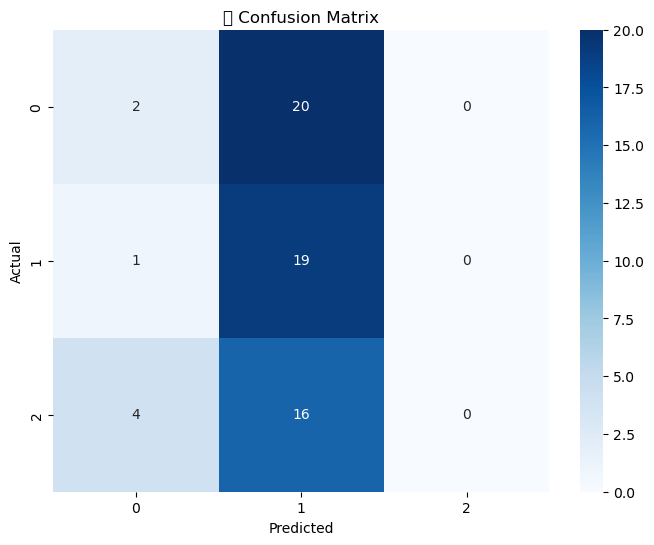

✅ ROC AUC Score: 0.6955


(0.3387096774193548,
 0.21281943862589023,
 0.3387096774193548,
 0.21238413051538746)

In [26]:
model_2, callbacks_2 = define_model(
    optimizer_name='Adam',
    dropout_rate=0.3,
    learning_rate=0.001,
    early_stopping=True,
    input_shape=X_train.shape[1:], 
    num_classes=len(np.unique(Y_train))  
)

history_2 = model_2.fit(
    X_train, Y_train,                  
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=callbacks_2,
    verbose=1
)

loss_curve_plot(history_2)

evaluate_model(model_2, X_test, Y_test)  


### instance 3

Epoch 1/500
31/31 [==============================] - 5s 157ms/step - loss: 2.2436 - accuracy: 0.6949 - val_loss: 4.5055 - val_accuracy: 0.3388
Epoch 2/500
31/31 [==============================] - 5s 152ms/step - loss: 1.2053 - accuracy: 0.8418 - val_loss: 2.1852 - val_accuracy: 0.3061
Epoch 3/500
31/31 [==============================] - 5s 151ms/step - loss: 0.8926 - accuracy: 0.9153 - val_loss: 3.7864 - val_accuracy: 0.5388
Epoch 4/500
31/31 [==============================] - 5s 148ms/step - loss: 0.8179 - accuracy: 0.9449 - val_loss: 3.0723 - val_accuracy: 0.3224
Epoch 5/500
31/31 [==============================] - 5s 149ms/step - loss: 0.7834 - accuracy: 0.9571 - val_loss: 4.5462 - val_accuracy: 0.3061
Epoch 6/500
31/31 [==============================] - 5s 149ms/step - loss: 0.7130 - accuracy: 0.9622 - val_loss: 5.0516 - val_accuracy: 0.3592
Epoch 7/500
31/31 [==============================] - 5s 150ms/step - loss: 0.7290 - accuracy: 0.9612 - val_loss: 3.6124 - val_accuracy: 0.3429

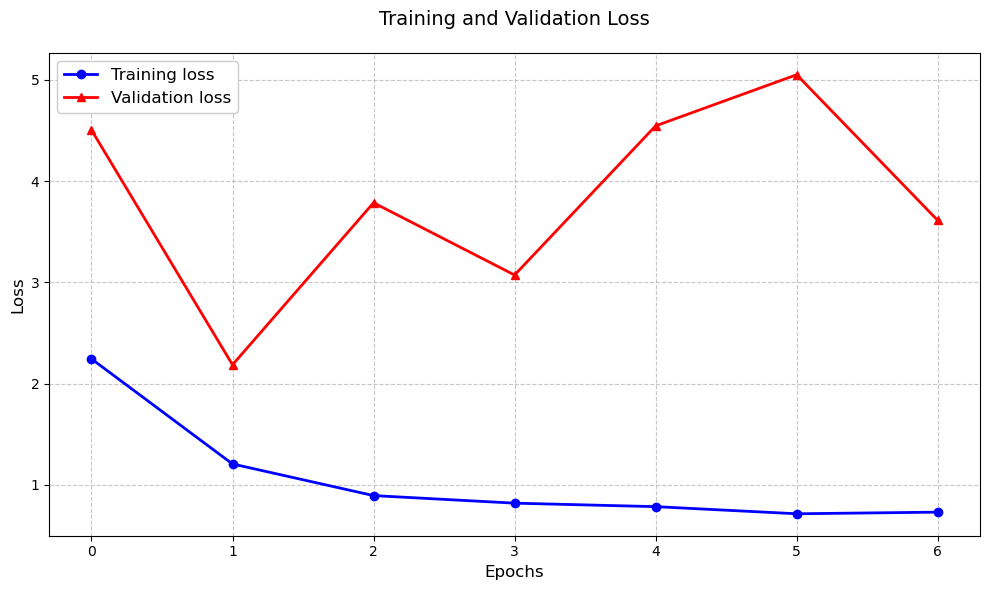

2/2 [==============================] - 0s 58ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.32      1.00      0.49        20
           2       0.00      0.00      0.00        20

    accuracy                           0.32        62
   macro avg       0.11      0.33      0.16        62
weighted avg       0.10      0.32      0.16        62

✅ Accuracy:  0.3226
✅ Precision: 0.1041
✅ Recall:    0.3226
✅ F1 Score:  0.1574


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

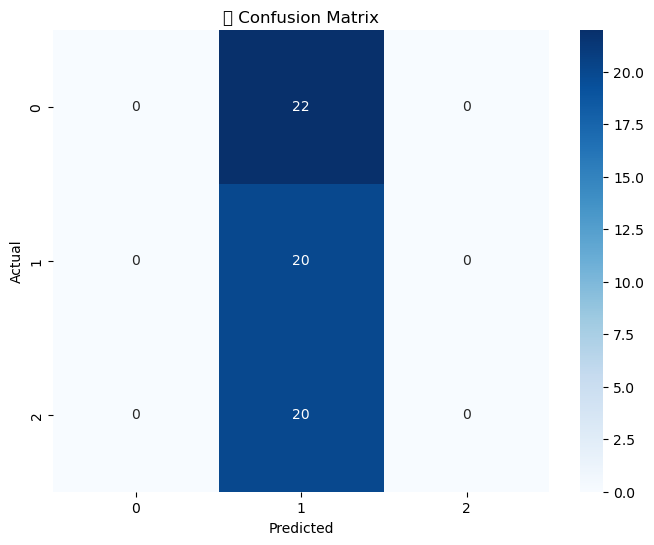

✅ ROC AUC Score: 0.8029


(0.3225806451612903,
 0.1040582726326743,
 0.3225806451612903,
 0.15735641227380015)

In [27]:
model_3, callbacks_3 = define_model(
    optimizer_name='RMSprop',
    regularizer_type='l2',
    dropout_rate=0.2,
    learning_rate=0.0005,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_3 = model_3.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_3, verbose=1)
loss_curve_plot(history_3)
evaluate_model(model_3, X_test, Y_test)


### instance 4

Epoch 1/500
24/24 [==============================] - 6s 201ms/step - loss: 30.2693 - accuracy: 0.7357 - val_loss: 30.3725 - val_accuracy: 0.3388
Epoch 2/500
24/24 [==============================] - 5s 195ms/step - loss: 28.9545 - accuracy: 0.9480 - val_loss: 29.6816 - val_accuracy: 0.3388
Epoch 3/500
24/24 [==============================] - 5s 192ms/step - loss: 27.8335 - accuracy: 0.9939 - val_loss: 28.7415 - val_accuracy: 0.3388
Epoch 4/500
24/24 [==============================] - 5s 195ms/step - loss: 26.6533 - accuracy: 0.9980 - val_loss: 27.6416 - val_accuracy: 0.3388
Epoch 5/500
24/24 [==============================] - 5s 194ms/step - loss: 25.3932 - accuracy: 0.9990 - val_loss: 26.3184 - val_accuracy: 0.3388
Epoch 6/500
24/24 [==============================] - 5s 191ms/step - loss: 24.0744 - accuracy: 1.0000 - val_loss: 24.9687 - val_accuracy: 0.3388
Epoch 7/500
24/24 [==============================] - 5s 191ms/step - loss: 22.7258 - accuracy: 1.0000 - val_loss: 23.4415 - val_ac

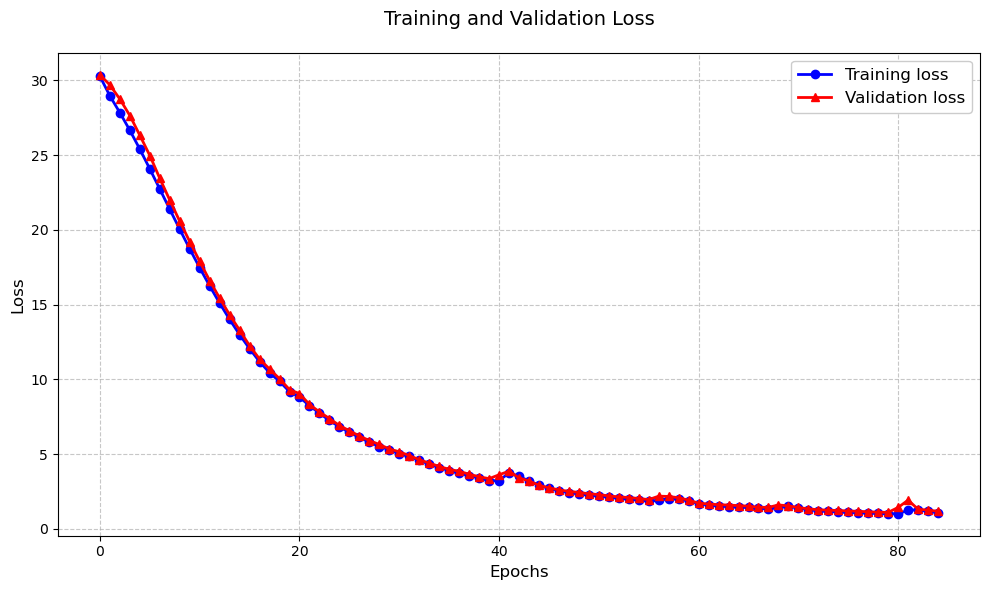

2/2 [==============================] - 0s 54ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.97        20

    accuracy                           0.98        62
   macro avg       0.98      0.98      0.98        62
weighted avg       0.98      0.98      0.98        62

✅ Accuracy:  0.9839
✅ Precision: 0.9846
✅ Recall:    0.9839
✅ F1 Score:  0.9839


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


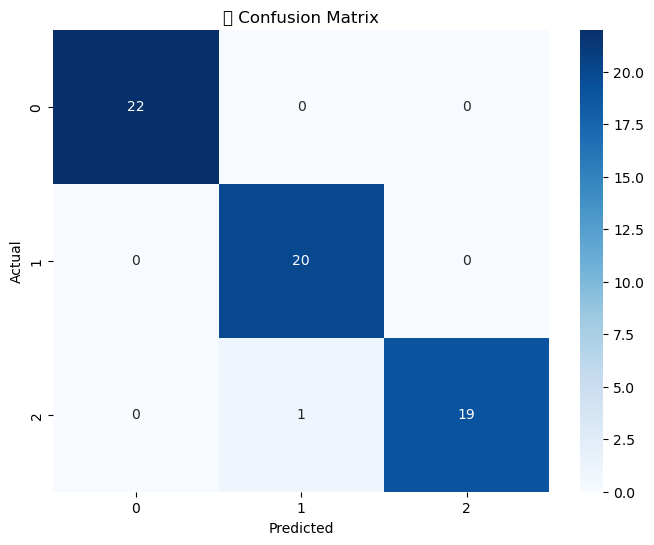

✅ ROC AUC Score: 0.9988


(0.9838709677419355,
 0.9846390168970814,
 0.9838709677419355,
 0.9838608807924308)

In [28]:
model_4, callbacks_4 = define_model(
    optimizer_name='Adam',
    regularizer_type='l1',
    learning_rate=0.0001,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_4 = model_4.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=42, callbacks=callbacks_4, verbose=1)
loss_curve_plot(history_4)
evaluate_model(model_4, X_test, Y_test)


### instance 5

Epoch 1/500
31/31 [==============================] - 6s 165ms/step - loss: 27.2987 - accuracy: 0.7602 - val_loss: 24.3724 - val_accuracy: 0.3102
Epoch 2/500
31/31 [==============================] - 5s 164ms/step - loss: 18.1039 - accuracy: 0.9235 - val_loss: 16.9662 - val_accuracy: 0.3429
Epoch 3/500
31/31 [==============================] - 5s 164ms/step - loss: 11.9855 - accuracy: 0.9500 - val_loss: 12.0374 - val_accuracy: 0.3061
Epoch 4/500
31/31 [==============================] - 5s 161ms/step - loss: 8.1234 - accuracy: 0.9582 - val_loss: 8.6818 - val_accuracy: 0.3388
Epoch 5/500
31/31 [==============================] - 5s 165ms/step - loss: 5.8026 - accuracy: 0.9612 - val_loss: 7.3523 - val_accuracy: 0.3061
Epoch 6/500
31/31 [==============================] - 5s 168ms/step - loss: 4.4795 - accuracy: 0.9571 - val_loss: 5.5256 - val_accuracy: 0.3061
Epoch 7/500
31/31 [==============================] - 5s 163ms/step - loss: 4.2472 - accuracy: 0.9337 - val_loss: 5.8120 - val_accuracy: 

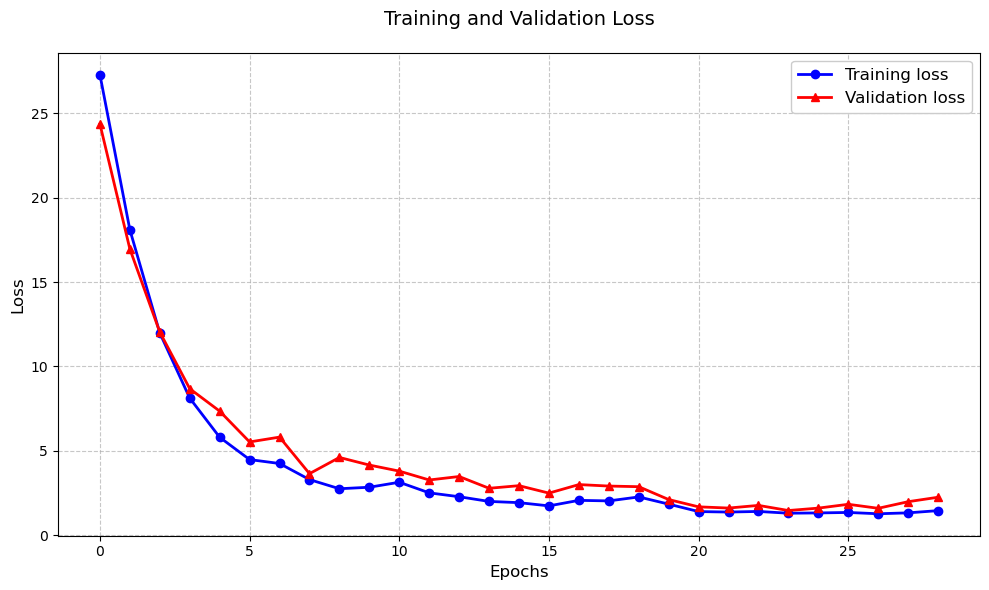

2/2 [==============================] - 0s 58ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.95      0.82        22
           1       0.90      0.90      0.90        20
           2       1.00      0.65      0.79        20

    accuracy                           0.84        62
   macro avg       0.87      0.83      0.84        62
weighted avg       0.87      0.84      0.84        62

✅ Accuracy:  0.8387
✅ Precision: 0.8699
✅ Recall:    0.8387
✅ F1 Score:  0.8367


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


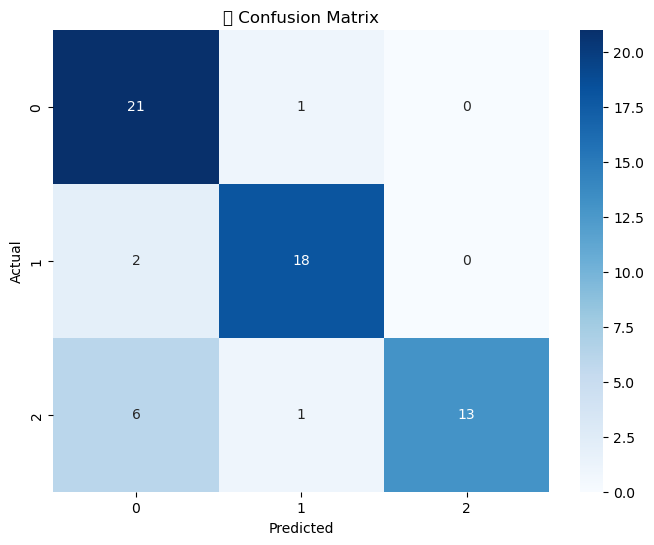

✅ ROC AUC Score: 0.9692


(0.8387096774193549,
 0.8698553948832035,
 0.8387096774193549,
 0.8366971421999885)

In [29]:
model_5, callbacks_5 = define_model(
    optimizer_name='SDG',
    # dropout_rate=0.001,
    regularizer_type='l1',
    learning_rate=0.0006,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_5 = model_5.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_5, verbose=1)
loss_curve_plot(history_5)
evaluate_model(model_5, X_test, Y_test)


# Save the best model compare all model

In [55]:
# Evaluate all models and select the best one
results = {}
models = [model_1, model_2, model_3, model_4, model_5]

for i, model in enumerate(models, start=1):
    print(f"\n🔍 Evaluating model_{i}")
    
    # Compute basic metrics
    acc, prec, rec, f1, roc_auc = evaluate_model(model, X, Y, show=False)
    
    results[f"model_{i}"] = {
        "model": model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
    }

# Create DataFrame (excluding model objects)
results_df = pd.DataFrame({
    name: {k: v for k, v in metrics.items() if k != 'model'}
    for name, metrics in results.items()
}).T

# Display full metrics sorted by F1
print("\n📋 All Models Performance (sorted by F1):")
print(results_df.sort_values(by="f1", ascending=False))

# Select best model: prioritize F1 > ROC AUC > Accuracy
def model_score(metrics):
    return (
        metrics["f1"],
        metrics["roc_auc"] if metrics["roc_auc"] is not None else 0,
        metrics["accuracy"]
    )

best_model_name = max(results, key=lambda k: model_score(results[k]))
best_model_metrics = results[best_model_name]
best_model = best_model_metrics["model"]

# Final output
print(f"\n🏆 Best model: {best_model_name}")
print("📌 Metrics:")
print(f"  F1 Score:   {best_model_metrics['f1']:.4f}")
if best_model_metrics["roc_auc"] is not None:
    print(f"  ROC AUC:    {best_model_metrics['roc_auc']:.4f}")
print(f"  Accuracy:   {best_model_metrics['accuracy']:.4f}")
print(f"  Precision:  {best_model_metrics['precision']:.4f}")
print(f"  Recall:     {best_model_metrics['recall']:.4f}")
# 📤 Save the best model to disk
model_filename = f"{best_model_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"\n💾 Best model saved to: {model_filename}")


🔍 Evaluating model_1
48/48 [==============================] - 2s 50ms/step
✅ ROC AUC Score: 0.9986

🔍 Evaluating model_2
48/48 [==============================] - 2s 50ms/step
✅ ROC AUC Score: 0.7427

🔍 Evaluating model_3
 1/48 [..............................] - ETA: 3s

/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 [==============================] - 2s 50ms/step
✅ ROC AUC Score: 0.8374

🔍 Evaluating model_4
 1/48 [..............................] - ETA: 3s

/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


48/48 [==============================] - 2s 52ms/step
✅ ROC AUC Score: 0.9997

🔍 Evaluating model_5
48/48 [==============================] - 3s 53ms/step
✅ ROC AUC Score: 0.9743

📋 All Models Performance (sorted by F1):
         accuracy  precision    recall        f1   roc_auc
model_4  0.988903   0.989036  0.988903  0.988903  0.999685
model_1  0.984987   0.985089  0.984987  0.985000  0.998551
model_5  0.874021   0.894342  0.874021  0.873354  0.974306
model_2  0.373368   0.295515  0.373368  0.247461  0.742674
model_3  0.326371   0.106518  0.326371  0.160616  0.837377

🏆 Best model: model_4
📌 Metrics:
  F1 Score:   0.9889
  ROC AUC:    0.9997
  Accuracy:   0.9889
  Precision:  0.9890
  Recall:     0.9889

💾 Best model saved to: model_4.pkl


## Model Summarries

In [35]:
## Model Summarries
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_28 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_29 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [36]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_32 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_33 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [37]:
model_3.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_36 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_37 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

In [38]:
model_4.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_40 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_41 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                     

In [39]:
model_5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_44 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_45 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                     

# Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [56]:
from joblib import load
def make_predictions(model_path, X):
    # Load the trained model from file
    model = load(model_path)
    
    # Check if classifier supports probability prediction
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)
        predictions = np.argmax(y_prob, axis=1)
    else:
        predictions = model.predict(X)
    
    return predictions


In [68]:
import numpy as np

# Index of the sample you want to predict
idx = 1

# Prepare input with batch dimension
single_input = np.expand_dims(X_test[idx], axis=0)

# Make prediction (assuming model outputs probabilities)
preds = make_predictions("model_4.pkl", single_input)

# Actual label
actual_label = Y_test[idx]

# Extract the predicted probabilities for the first sample
pred_probs = preds[0]  # e.g. [0.0651, 0.0179, 0.9170]

# Get the predicted class as the index with the max probability
pred_label = np.argmax(pred_probs)

print(f"Actual label:    {actual_label}")
print(f"Predicted label: {pred_label}")
print(f"Probabilities:   {pred_probs}")


1/1 [==============================] - 0s 86ms/step
Actual label:    0
Predicted label: 0
Probabilities:   [0.95802844 0.02748761 0.01448396]
1/1 [==============================] - 0s 86ms/step
Actual label:    0
Predicted label: 0
Probabilities:   [0.95802844 0.02748761 0.01448396]


Congratulations!!
